## **Train and Export Tree Classifier**

This notebook draws heavily on Fastai course, in particular:

- [Lesson 3](https://course.fast.ai/Lessons/lesson2.html)

In [15]:
!pip install -Uqq fastai
!pip install -Uqq nbdev
!pip install -Uqq duckduckgo_search

In [35]:
from fastai.vision.all import *
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep
import shutil
from fastai.vision.widgets import *
import os

In [65]:
import warnings
warnings.filterwarnings('ignore')

#### **Get Training Images**


According to [this article](https://www.woodlandtrust.org.uk/blog/2018/12/what-are-the-most-common-trees-in-the-uk/) the most common trees in the UK are: Alder, Beech, Oak, Hawthorn, Hazel, Holly, Rowan, Silver Birch, Small Leaved Lime and White Willow.

These are the trees that this app can categorise. In current version the does not have null hypothesis.

This section will search the internet for tree pictures and save them in their respective folders within the top level folder 'trees'.

In [17]:
#What types of plant are we interested in?
plant_list = ['Alder', 'Beech', 'Oak', 'Hawthorn', 'Hazel','Holly', 'Rowan', 'Silver Birch', 'Small Leaved Lime', 'White Willow']

In [18]:
#function to find the images
def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [19]:
#where I am going to save the plant photos
path = Path('trees')


for i in plant_list:
    #make the directory
    dest = (path/i)
    
    #if you want to delete a directory
#     shutil.rmtree(dest)

    #download the images
    if dest.is_dir():
        print(f'{dest} already exists, skipping...')
    else:
        dest.mkdir(exist_ok=true,parents=True)
        #download the images
        download_images(dest, urls=search_images(f'{i} tree leaf',max_images=75))
        sleep(10)
        download_images(dest, urls=search_images(f'{i} tree small branches with leaves',max_images=75))
        sleep(10)

    print(f'{len(get_image_files(dest))} image files in {dest}')
    

trees/Alder already exists, skipping...
143 image files in trees/Alder
trees/Beech already exists, skipping...
140 image files in trees/Beech
trees/Oak already exists, skipping...
136 image files in trees/Oak
trees/Hawthorn already exists, skipping...
142 image files in trees/Hawthorn
trees/Hazel already exists, skipping...
138 image files in trees/Hazel
trees/Holly already exists, skipping...
141 image files in trees/Holly
trees/Rowan already exists, skipping...
145 image files in trees/Rowan
trees/Silver Birch already exists, skipping...
144 image files in trees/Silver Birch
trees/Small Leaved Lime already exists, skipping...
136 image files in trees/Small Leaved Lime
trees/White Willow already exists, skipping...
145 image files in trees/White Willow


In [20]:
#find the images that can't be opened
failed = verify_images(get_image_files(path))
#apply Path.unlink to every item in Path
failed.map(Path.unlink)

(#0) []

#### **Create Data Loader**

In [21]:
trees = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, #will pass the path as an input variable to the datablock object
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)) #this will crop the image

dls_tree = trees.dataloaders(path)

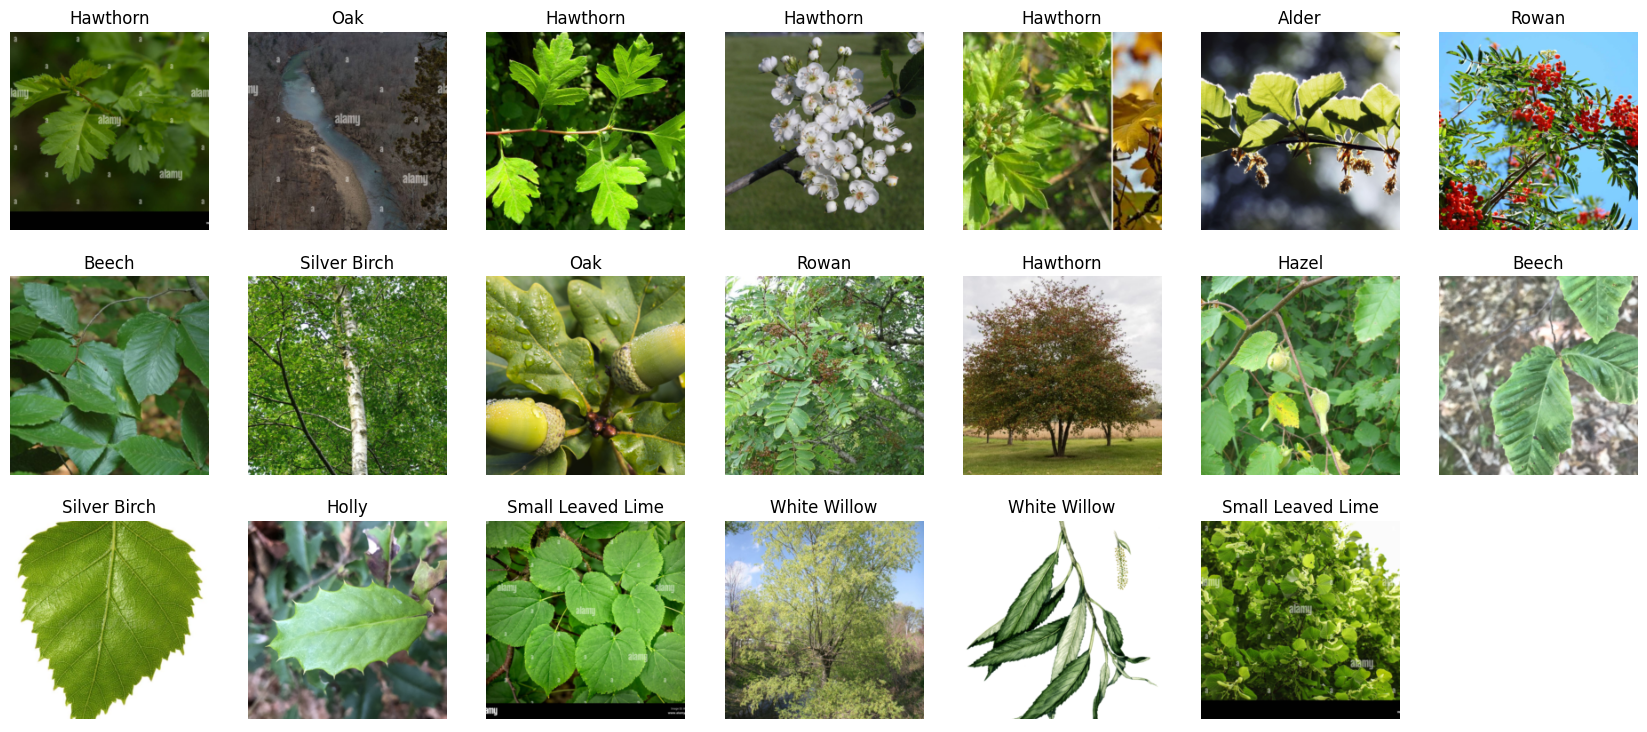

In [22]:
dls_tree.valid.show_batch(max_n = 20, nrows = 3)

#### **Train Model to Clean Data**

Taking model choice guidance from this [notebook](https://www.kaggle.com/code/jhoward/which-image-models-are-best/).

In [23]:
#create learner
learn = vision_learner(dls_tree, 'levit_conv_384.fb_dist_in1k', metrics=error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


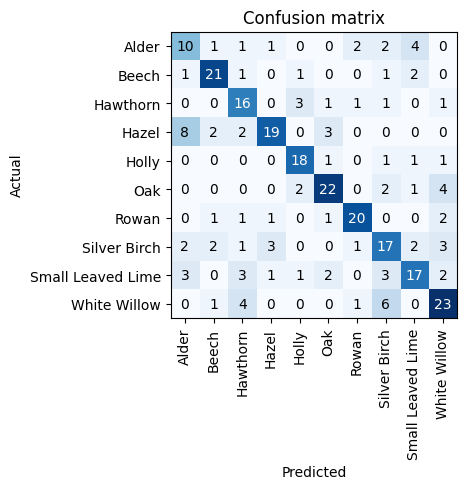

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

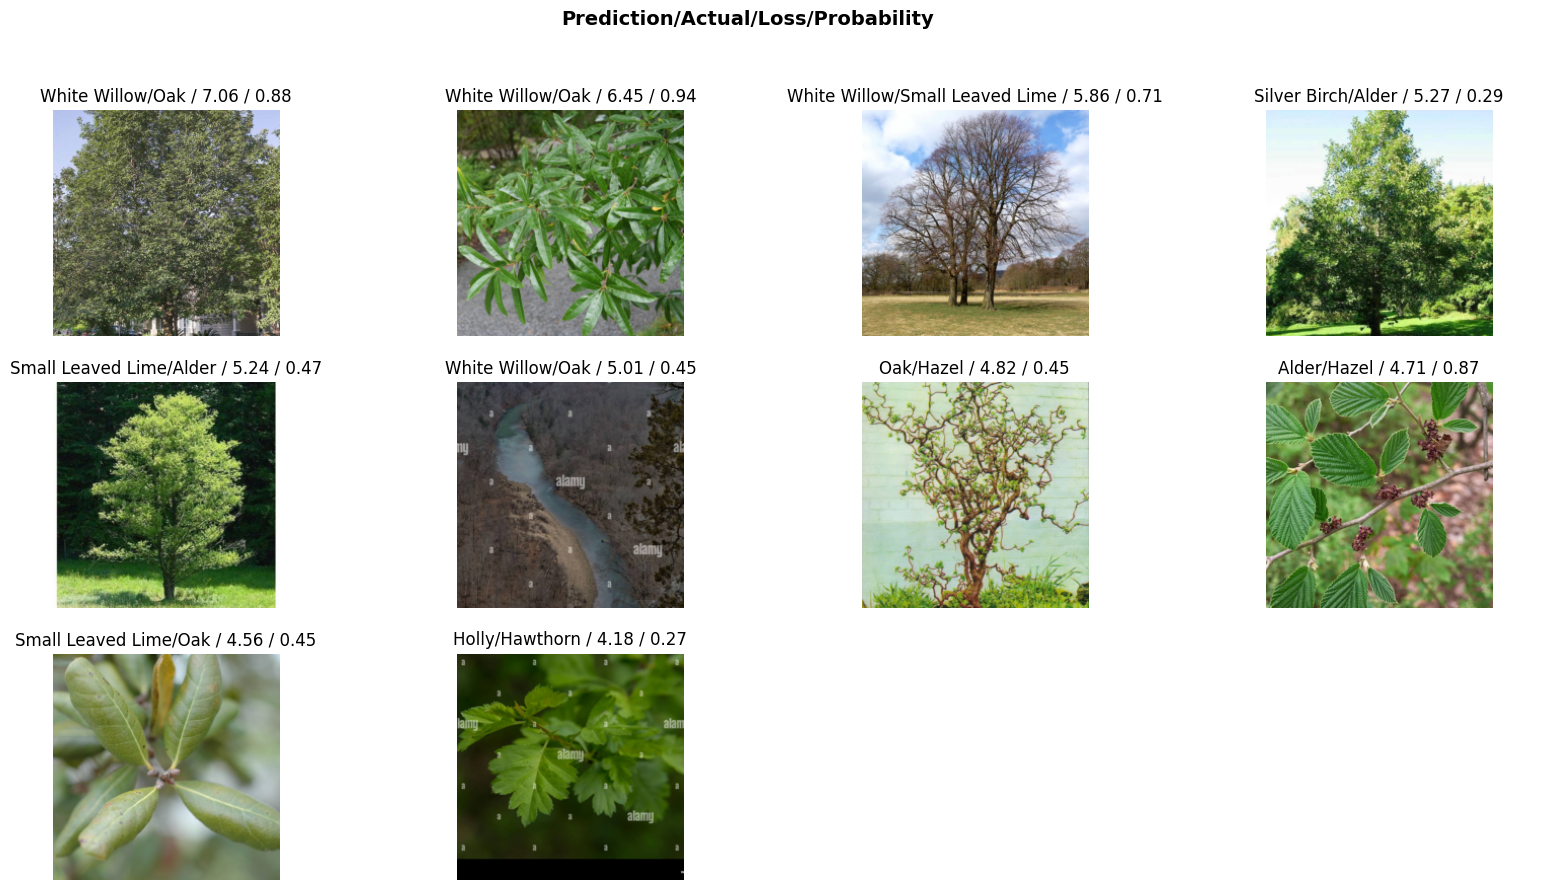

In [25]:
interp.plot_top_losses(10, nrows = 3, figsize = (20,10))

In [26]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
for idx in cleaner.delete():
    file_path = cleaner.fns[idx]
    print(f"Deleting file: {file_path}")
    os.remove(file_path)

#### **Train Model For Deployment**

According to min 16 of [lesson 2](https://course.fast.ai/Lessons/lesson2.html):

> 'Generally speaking, if you are training for more than 5 or 10 epochs (most the time) will want to use random resize crop and aug transforms!'

Which I do below!

In [55]:
trees = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, #will pass the path as an input variable to the datablock object
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.4),
    batch_tfms = aug_transforms)

dls_tree = trees.dataloaders(path)

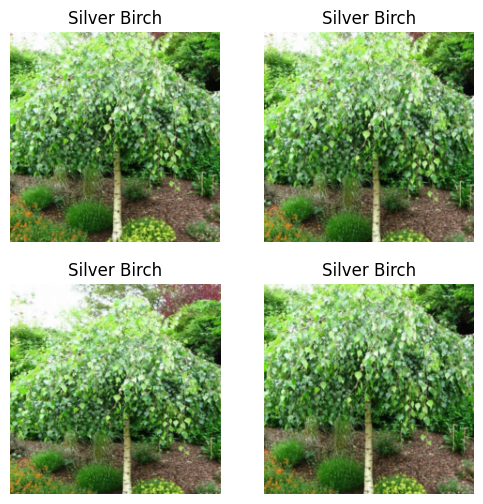

In [56]:
dls_tree.train.show_batch(max_n = 4, nrows = 2, unique = True)

In [57]:
#create learner
learn = vision_learner(dls_tree, 'levit_conv_384.fb_dist_in1k', metrics=error_rate)

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should b

SuggestedLRs(valley=0.0012022644514217973)

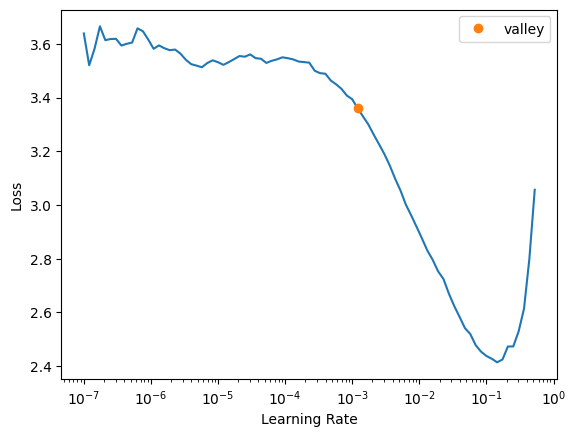

In [58]:
#find the ideal learning rate
learn.lr_find()

Interesting article on [fine_tune vs fit_one_cycle](https://forums.fast.ai/t/fine-tune-vs-fit-one-cycle/66029). Fine_tune tends to work better for transfer learning!

In [63]:
learn.fine_tune(epochs = 10, base_lr = 0.0012)

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should b

#### **Save the Model**

In [64]:
# learn.export('model.pkl')